In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import requests

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.5
Running on ArviZ v0.12.1


# PyMC3 primer

In [4]:
# Let's create our dataset for the flipping coin problem
np.random.seed(123)
trials = 4
theta_real = 0.35  # unknown value in a real experiment (pretend to know it)
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data #this is what you observe

array([1, 0, 0, 0])

In [5]:
# Let's create our model in PyMC3

# the following creates a sort of container of our model
with pm.Model() as model: #everything inside the with block will add to our_first_model
    # prior
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data) #using observed data tells PyMC this is the likelihood
  
    #"The Inference Button"
    idata = pm.sample(1000, random_seed=123, return_inferencedata=True) #https://docs.pymc.io/en/v3/api/inference.html

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


With PyMC3 version >=3.9 the return_inferencedata=True kwarg makes the sample function return an arviz.InferenceData object instead of a MultiTrace. InferenceData has many advantages, compared to a MultiTrace: For example it can be saved/loaded from a file, and can also carry additional (meta)data such as date/version, or posterior predictive distributions. See [here](https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/api_quickstart.html#3.1-Sampling) 

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Notes</b><br>
    <p style="color: black">
        (i) $\theta$ is used first as a Python variable then as the first argument of the Beta function; using the same name is a good practice to avoid confusion.
        The $\theta$ variable is a random variable; it is not a number but an object representing a probability distribution from which we can compute random numbers and probability densiities. 
    </p>
    $\theta \sim Beta (\alpha, \beta)$ 
    <br>
    </br>
    $y \sim Bern (p=\theta)$ 

 <p  style="color: black">
 (ii) Notice that using the observed data says to PyMC we are working with a Likelihood (in the example above is Bernoulli). The values of the data can be passed either as a Python list, a tuple, a numpy array or a pandas DataFrame. 
 </p>

 <p  style="color: black">
 (iii) The last line, with trace, is known as the "Inference Button". We are asking for 1000 samples from the posterior and will store them in the trace object. pyMC3 is doing a lot of things under the hood:
    
    (a) Auto-assigning NUTS sampler...  (NUTS is an inference engine for continuous variables)

    (b) Initializing NUTS using jitter+adapt_diag... (method for initiliazing the sampler)

    (c) Multiprocess sampling (4 chains in 4 jobs) (PyMC3 will run 4 chains in parallel; we will get 4 independnent samples from the posterior at the price of one; this is done taking into account the number of processors in your machine by default; otherwise, you can specify in the sample the argument 'chains')

    (d) NUTS: [θ] (It tells us which variables are being sampled by which sampler. This is useful when things are more complicated than the problem we are dealing which has only θ)
 </p>
</div>




<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
        Suppose we asked 1000 samples. The autotuning of NUTS takes 1000 iterations. If you have n chains, each will be 2000 (=500+1000). Therefore the total number of iterations is going to be: 2000*n       
    </p>
</div>

In [6]:
#print(idata)
#print(np.shape(idata), type(idata))
print(idata['posterior']['θ'][2])

<xarray.DataArray 'θ' (draw: 1000)>
array([0.60963134, 0.07679023, 0.19129568, 0.29830615, 0.21400052,
       0.1053212 , 0.27009106, 0.27094604, 0.2214697 , 0.10564759,
       0.15467179, 0.11699343, 0.14895235, 0.37183134, 0.43143346,
       0.43143346, 0.41940235, 0.41940235, 0.59400186, 0.71951305,
       0.7232298 , 0.7232298 , 0.69794201, 0.42358926, 0.42358926,
       0.74829387, 0.626497  , 0.626497  , 0.34008156, 0.5805151 ,
       0.42772445, 0.46690363, 0.46690363, 0.46690363, 0.34911197,
       0.34911197, 0.38772612, 0.52285569, 0.52285569, 0.35962145,
       0.16259437, 0.22690016, 0.16101297, 0.1913765 , 0.07980741,
       0.10422112, 0.17239293, 0.15660685, 0.53588548, 0.40969163,
       0.21012779, 0.17732373, 0.48837368, 0.43422846, 0.43422846,
       0.32157057, 0.27321873, 0.52633522, 0.40489504, 0.66990864,
       0.41415308, 0.24574129, 0.37064859, 0.30926891, 0.30926891,
       0.31872462, 0.6889091 , 0.24717509, 0.1889346 , 0.16069671,
       0.17429194, 0.15390

### Summarizing the posterior

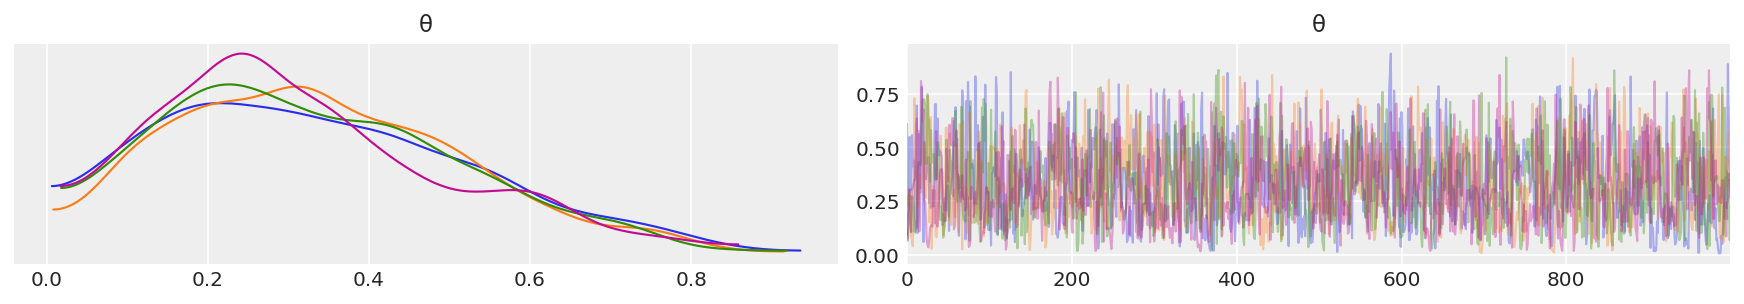

In [7]:
az.plot_trace(idata, combined = False, compact=False)
plt.savefig('./output/B11197_02_01.png')

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b>
    <p style="color: black">      
        Depending on the number of chains (N), you have N curves.
        <br></br>
        The plots on the left are obtained from Kernel Desinity Estimation (KDE) of the corresponding histograms, while the plots on the right are the sampled values from each chain.      
        <br></br>
        You should compare these curves with those obtained analytically in the previous lecture.
    </p>
</div>

In [8]:
#it returns a Pandas dataframe
az.summary(idata)
# Got error No model on context stack. if return_inferencedata=False
# However, if return_inferencedata=False trace['θ'] not found... 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.332,0.18,0.016,0.65,0.005,0.003,1418.0,1928.0,1.0


That's the mean from all the chains... 
HDI are simple to understand at this point. The other metrics will be explained in the following lectures, but for now know that they are used to interpret the results of a Bayesian inference.

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
    HPD: High Posterior Density;  HDI: is the highest density interval. Another way of summarizing a distribution, which we will use often, abbreviated HDI. The HDI indicates which points of a distribution are most credible, and which cover most of the distribution.

 
They are often used as synonyms in the legends of the plots. 
        
   </p>
</div>

#### Posterior-based decisions (Is the coin fair?)

Strictly speaking, a fair coin $\theta$=0.5. But the probability of observing exactly 0.5 is practcally 0. We can relax this definition of fairness to a Region of Practical Equivalence (ROPE), say [0.45,0.55] (it depends on your expectations and prior knowledge and it is always context-dependent). 

There are three scenarios:
- the ROPE does not overlap with the HDI; the coin is not fair
- the ROPE contains the entire HDI; the coin is fair
- the ROPE partially overlaps with HDI; we cannot make any conclusions

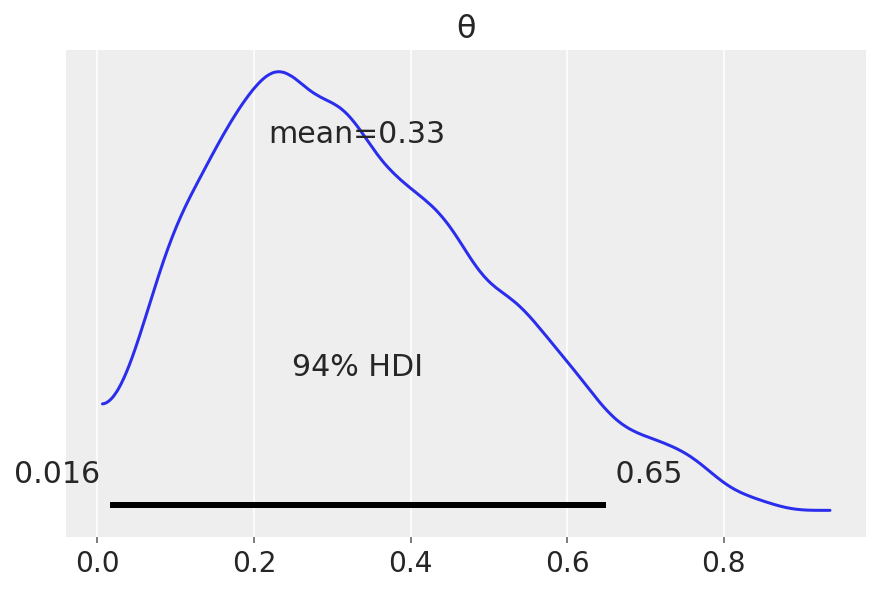

In [9]:
az.plot_posterior(idata)
plt.savefig('./output/B11197_02_02.png', dpi=300)

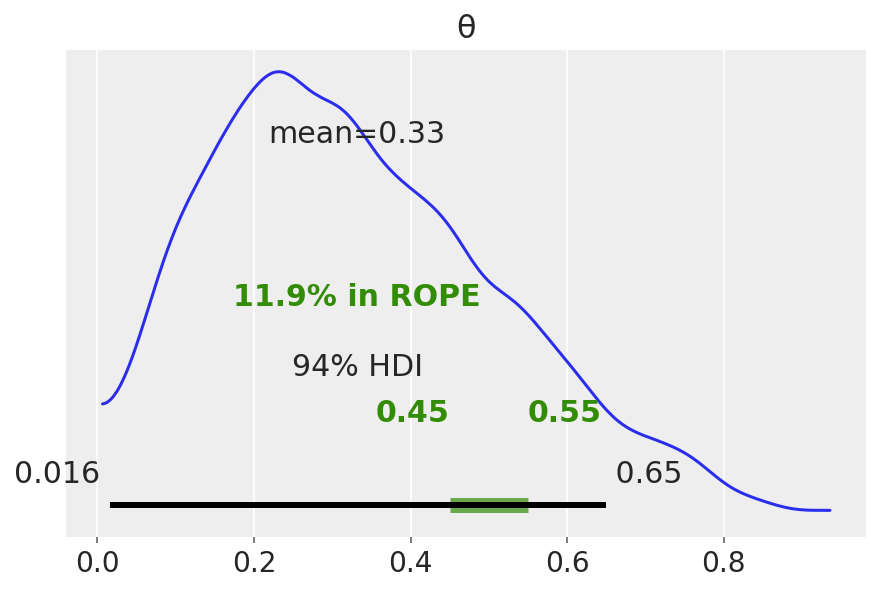

In [10]:
az.plot_posterior(idata, rope=[0.45, .55])
plt.savefig('./output/B11197_02_03.png', dpi=300)

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Notes</b><br>
    <p style="color: black">
    Unlike a frequentist approach, Bayesian inference is not based on statistical significance, where effects are tested against “zero”. Indeed, the Bayesian framework offers a probabilistic view of the parameters, allowing assessment of the uncertainty related to them. Thus, rather than concluding that an effect is present when it simply differs from zero, we would conclude that the probability of being outside a specific range that can be considered as “practically no effect” (i.e., a negligible magnitude) is sufficient. This range is called the region of practical equivalence <a href="https://easystats.github.io/bayestestR/articles/region_of_practical_equivalence.html"> (ROPE)</a>.
        
Therefore, the idea underlining ROPE is to let the user define an area around the null value enclosing values that are equivalent to the null value for practical purposes
        </p>
    </div>

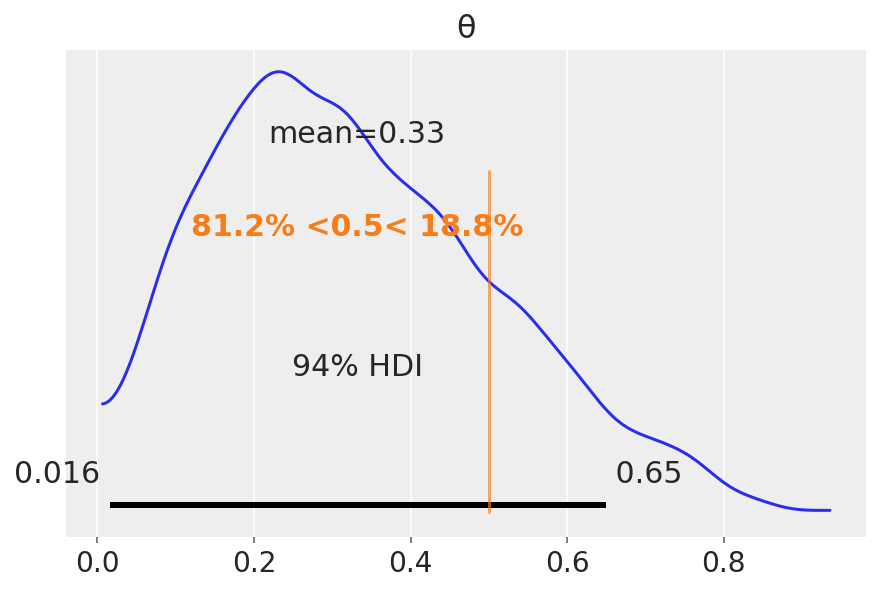

In [11]:
az.plot_posterior(idata, ref_val=0.5)
plt.savefig('./output/B11197_02_04.png', dpi=300)

### Loss functions: how close to the truth are we?

We can find the value of $\hat{\theta}$ that minimizes the loss function(s) below. 


<xarray.DataArray 'θ' (draw: 1000)>
array([0.09272553, 0.18068006, 0.21692534, 0.54884828, 0.30039944,
       0.30291883, 0.55677573, 0.41155764, 0.4385679 , 0.41230123,
       0.17422964, 0.10239599, 0.6947041 , 0.10233176, 0.1798867 ,
       0.56210745, 0.30942912, 0.56345865, 0.78120174, 0.60080637,
       0.05935994, 0.5258759 , 0.46406574, 0.35188727, 0.40319118,
       0.40319118, 0.45509316, 0.24060721, 0.42100497, 0.21904915,
       0.29948417, 0.24621027, 0.22497228, 0.4707984 , 0.70133497,
       0.70133497, 0.3517801 , 0.6349532 , 0.51546164, 0.46187695,
       0.48389485, 0.474536  , 0.45821339, 0.1390673 , 0.14415375,
       0.24495161, 0.26292582, 0.20535491, 0.28918578, 0.32056558,
       0.32387456, 0.11082163, 0.28189887, 0.28189887, 0.3408447 ,
       0.36356173, 0.48492101, 0.6234203 , 0.50770975, 0.68746921,
       0.51573009, 0.53849572, 0.23929   , 0.08868204, 0.30950954,
       0.36403873, 0.269605  , 0.76575333, 0.71839938, 0.25883338,
       0.42600433, 0.07222

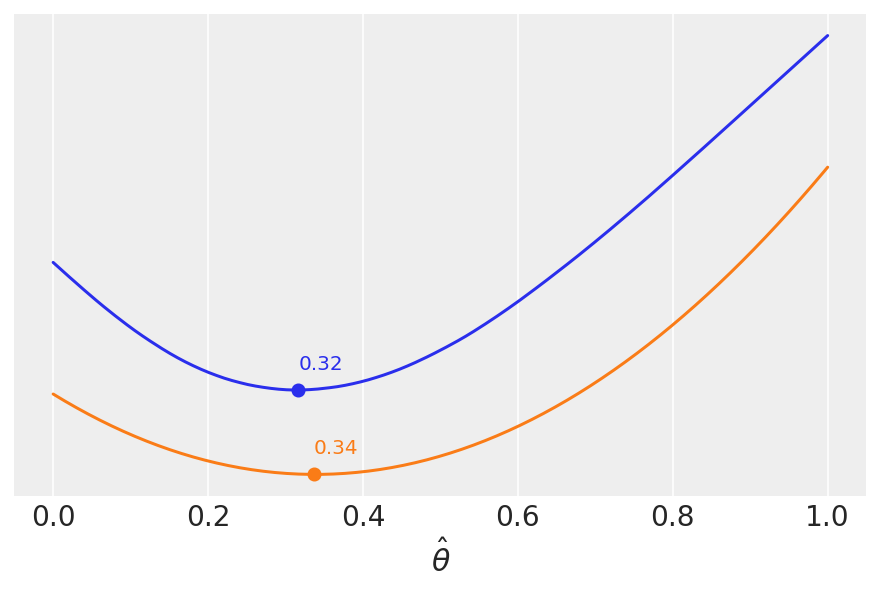

In [13]:
grid = np.linspace(0, 1, 200) #Le'ts explore a grid of 200 points
nchain = 0 
θ_pos = idata['posterior']['θ'][nchain] #for the nth first chain
print(θ_pos)

#------ here add also the "average" chain ------#


lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]  #Absolute Loss
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]  #Quadratic Loss


for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
plt.savefig('./output/B11197_02_05.png', dpi=300)

check_mean = np.mean(θ_pos)
check_median = np.median(θ_pos)
print('mean: {:3.2f}, median: {:3.2f}'.format(check_mean,check_median))

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-eye" aria-hidden="true"></i>&nbsp; Notice</b><br>
    <p style="color: black"> 
        We saw this heuristically (calculating the mean and the median), but the key message is that different loss functions are related to different point-estimates. Compare to the plot above. 
        <br></br>
        Cost functions could be asymmetric. 
        A dummy example is the following.
    </p>
</div> 

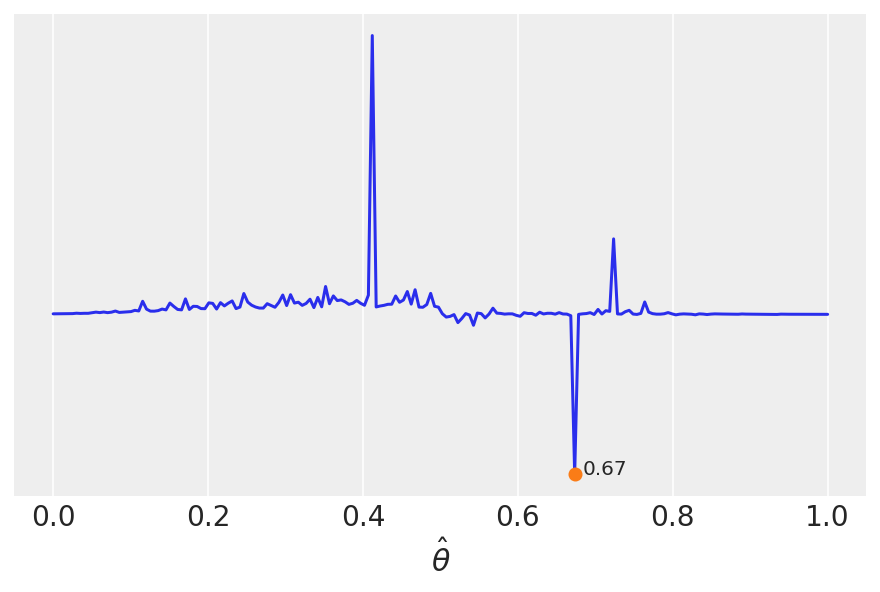

In [245]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig('./output/B11197_02_06.png', dpi=300)

### Gaussian inferences

[51.06 55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43
 53.   56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58
 51.36 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82
 54.99 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]


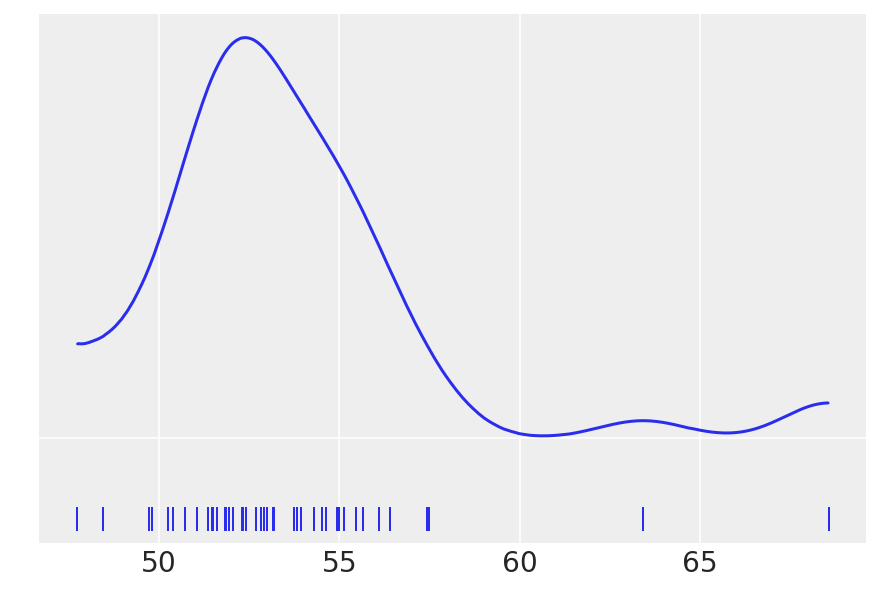

In [18]:
#https://medium.com/towards-entrepreneurship/importing-a-csv-file-from-github-in-a-jupyter-notebook-e2c28e7e74a5

import io
import csv 
import requests

local_data = True  

data = []

if local_data==True:
    input_path = '../../repo/brds/datasets/chemical_shifts.txt'
    data = np.loadtxt(input_path)

else:
    target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/chemical_shifts.csv'

    download = requests.get(target_url).content
    df = pd.read_csv(io.StringIO(download.decode('utf-8')))

    data=df.iloc[:,0].values

print(data)
    
az.plot_kde(data, rug=True) #rug plots https://en.wikipedia.org/wiki/Rug_plot 
plt.yticks([0], alpha=0)
plt.savefig('./output/B11197_02_07.png', dpi=300)


Kruschke-style diagram:
<img src="./images/B11197_02_08.png" width="500">

In [19]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


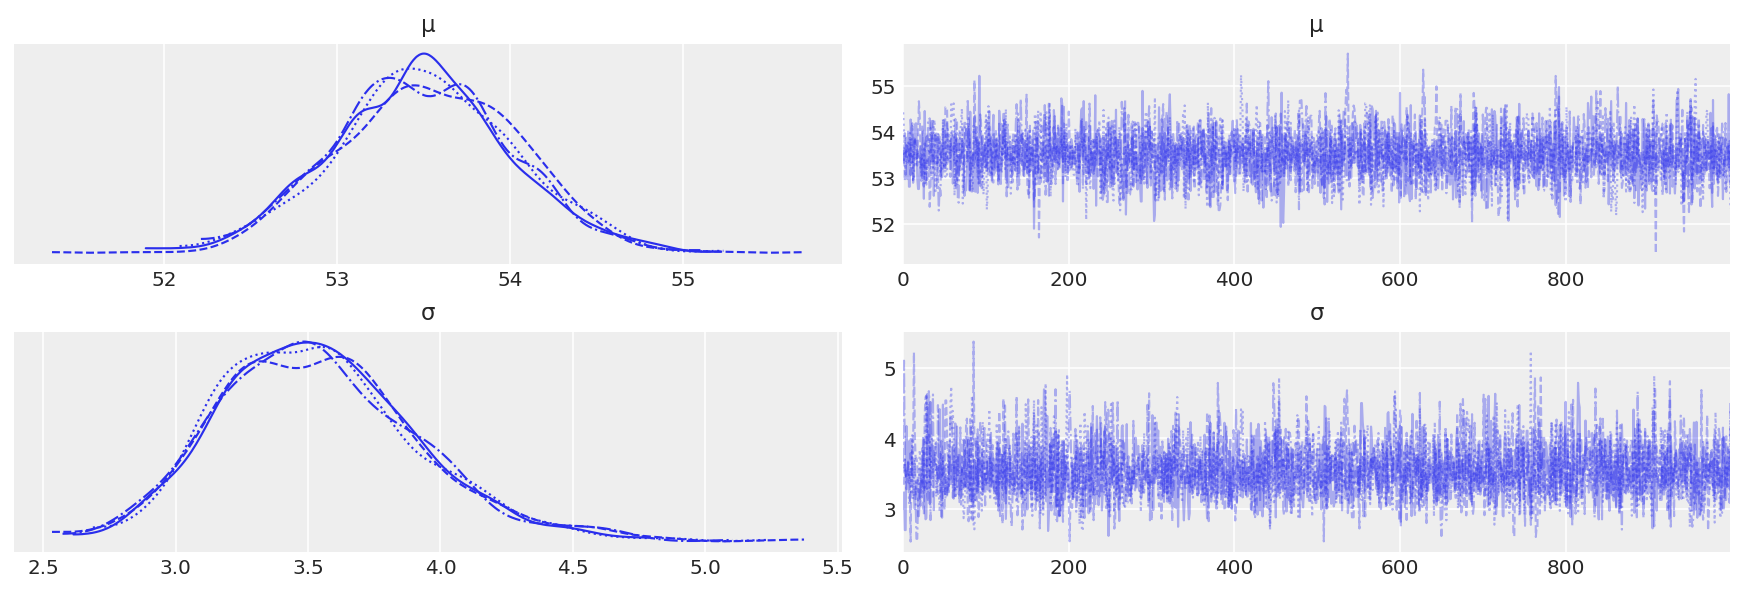

In [20]:
#THIS DOES NOT REALLY WORK...

az.plot_trace(trace_g)
plt.savefig('./output/B11197_02_09.png', dpi=300)

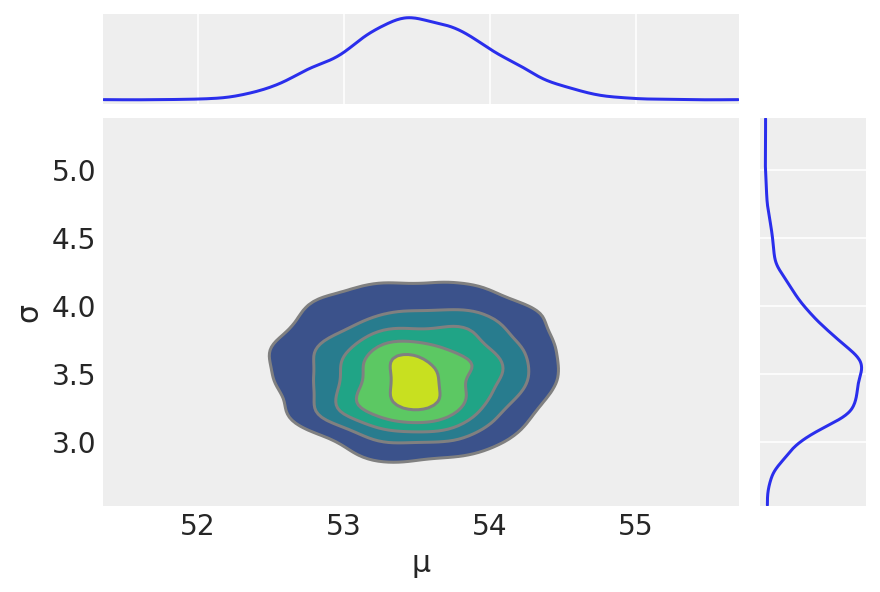

In [22]:
az.plot_pair(trace_g, kind='kde', fill_last=False, marginals=True)
plt.savefig('./output/B11197_02_10.png', dpi=300)

In [23]:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.508,0.514,52.561,54.483,0.009,0.006,3562.0,2801.0,1.0
σ,3.538,0.379,2.845,4.225,0.006,0.004,3591.0,2866.0,1.0


In [ ]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

In [ ]:
data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.savefig('./output/B11197_02_11.png', dpi=300)

### Robust inferences

In [ ]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('B11197_02_12.png', dpi=300)

 <img src="./images/B11197_02_13.png" width="500">

In [ ]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)

In [ ]:
az.plot_trace(trace_t)
plt.savefig('./output/B11197_02_14.png', dpi=300)

In [ ]:
az.summary(trace_t)

In [ ]:
y_ppc_t = pm.sample_posterior_predictive(
    trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
ax[0].legend(fontsize=15)
plt.xlim(40, 70)
plt.savefig('./output/B11197_02_15.png', dpi=300)

### Tips example

In [ ]:
tips = pd.read_csv('../../repo/BRDS/datasets/tips.csv')
tips.tail()

In [ ]:
sns.violinplot(x='day', y='tip', data=tips)
plt.savefig('./output/B11197_02_16.png', dpi=300)

In [ ]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

In [ ]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)
plt.savefig('./output/B11197_02_17.png', dpi=300)

In [ ]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()
plt.savefig('./output/B11197_02_18.png', dpi=300)

### Hierarchical Models

 <img src="./images/B11197_02_19.png" width="500">

In [ ]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [ ]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)

In [ ]:
az.plot_trace(trace_h)
plt.savefig('./output/B11197_02_20.png', dpi=300)

In [ ]:
az.summary(trace_h)

In [ ]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()
plt.savefig('B11197_02_21.png', dpi=300)

In [ ]:
cs_data = pd.read_csv('../../repo/BRDS/datasets/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

In [ ]:
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_nh = pm.sample(1000)

In [ ]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_h = pm.sample(1000)

In [ ]:
axes = az.plot_forest([trace_cs_nh, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)
plt.savefig('B11197_02_22.png', dpi=300)